Cat_A Cat_B Cat_C Cat_D Cat_E Cat_F files are similar. It just changes the category I ran the models on.

In phase 1 they were all executed.
In phase 2 the Cat_A file was executed in full. For the other files, due to GPU limitations, only some parts were executed based on the results obtained in phase 1 and 2

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/Challenge2

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/Challenge2


# Libraries


In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [4]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score



# Load and process data

In [9]:
# load the files .npy

training_data = np.load('training_dataset/training_data.npy') # (48000, 2776). 48000 time series of length 2776.
# the length of the time series in the training dataset is variable. -> padding with zeros the sequences to the maximum length of 2776

valid_periods = np.load('training_dataset/valid_periods.npy') #(48000, 2) containing for each of the time series the start and end index of the current series, i.e. the part without padding.
categories = np.load('training_dataset/categories.npy') # (48000,) containing for each of the time series the code of its category. Categories are {'A', 'B', 'C', 'D', 'E', 'F'}.

In [10]:
# use pandas to visualize data
training_data_df = pd.DataFrame(training_data)
valid_periods_df = pd.DataFrame(valid_periods, columns=['Start Index', 'End Index'])  # secify columns' names
categories_df = pd.DataFrame({'Category': categories}) # create a dictionary key <-> values


print("\nDati di addestramento:")
print(training_data_df.head())

print("\nPeriod range:")
print(valid_periods_df.head())

print("Categories:")
print(categories_df.head())

# as i can see, data are already normalyzed


Dati di addestramento:
   0     1     2     3     4     5     6     7     8     9     ...      2766  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.478704   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.628000   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.959741   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.411765   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.340909   

       2767      2768      2769      2770      2771      2772      2773  \
0  0.412963  0.501852  0.756481  0.744444  0.640741  0.516667  0.602778   
1  0.624000  0.644000  0.688000  0.740000  0.640000  0.536000  0.600000   
2  0.949098  0.919297  0.916705  0.901249  0.932531  0.955206  0.960481   
3  0.307030  0.325681  0.361549  0.430416  0.486370  0.450502  0.470588   
4  0.522727  0.568182  0.772727  0.681818  0.704545  0.863636  0.727273   

       2774      2775  
0  0.367593  0.33148

Category B: 10987 values
Category E: 10975 values
Category C: 10017 values
Category D: 10016 values
Category A: 5728 values
Category F: 277 values


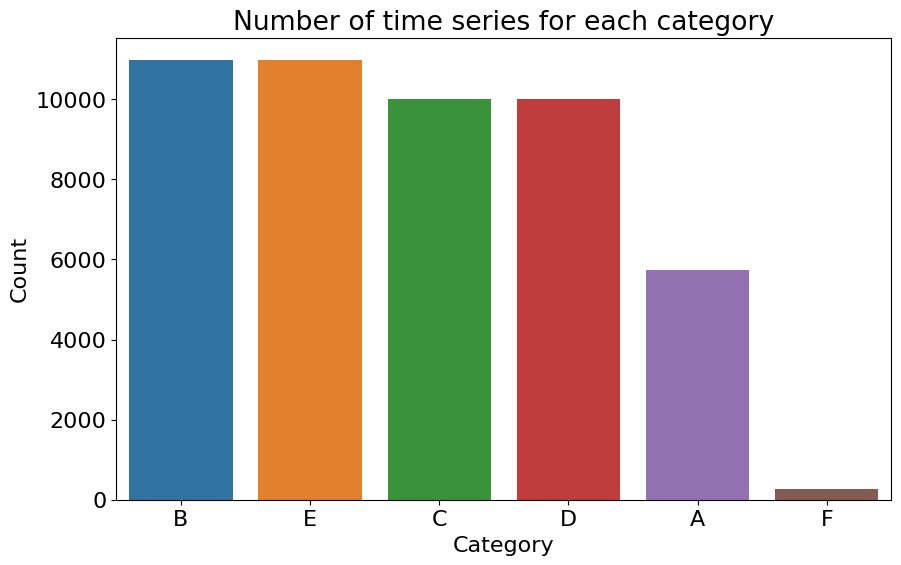

In [11]:
# Let's see how many time series we have for each category

# Count the occurrences of each category
category_counts = categories_df['Category'].value_counts()

# Prints the number of values for each category
for category, count in category_counts.items():
    print(f"Category {category}: {count} values")

# Plot the results
plt.figure(figsize=(10, 6))
sns.countplot(x='Category', data=categories_df, order=category_counts.index)
plt.title('Number of time series for each category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [12]:
# Create a dataframe with all the training_data, category, and start and end indices

dataset = pd.DataFrame(training_data)

# Add categories column
dataset['Category'] = categories

# Add start and end index columns
start_index = valid_periods[:, 0]
end_index = valid_periods[:, 1]
dataset['Start_index'] = start_index
dataset['End_index'] = end_index

# Display the first rows of the DataFrame
print(dataset.head())


     0    1    2    3    4    5    6    7    8    9  ...      2769      2770  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.756481  0.744444   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.688000  0.740000   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.916705  0.901249   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.361549  0.430416   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.772727  0.681818   

       2771      2772      2773      2774      2775  Category  Start_index  \
0  0.640741  0.516667  0.602778  0.367593  0.331481         D         2325   
1  0.640000  0.536000  0.600000  0.460000  0.396000         D         2325   
2  0.932531  0.955206  0.960481  0.946506  0.977140         D         2325   
3  0.486370  0.450502  0.470588  0.569584  0.571019         D         2712   
4  0.704545  0.863636  0.727273  0.818182  0.840909         D         2682   

   End_index  
0       2776  
1       2776  
2    

In [13]:
# Sorting DataFrame by 'Category' column
dataset = dataset.sort_values(by='Category')

print(dataset.head())

         0    1    2    3    4    5    6    7    8    9  ...      2769  \
23999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.122790   
24814  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.841143   
24813  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.898658   
24812  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.697608   
24811  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.273944   

           2770      2771      2772      2773      2774      2775  Category  \
23999  0.186651  0.019110  0.304162  0.019417  0.112557  0.135714         A   
24814  0.926898  0.954098  0.953775  0.952968  0.931200  0.949984         A   
24813  0.900994  1.000000  0.906275  0.927457  0.927743  0.853382         A   
24812  0.626714  0.501163  0.565343  0.673144  0.618114  0.698964         A   
24811  0.120231  0.000000  0.145096  0.139489  0.199748  0.398671         A   

       Start_index  End_index  
23999         2443       2776  
24814         23

In [14]:
# Visualize 5 random time series of one category

def inspect_time_series_by_category(df, category, num_samples=5):
    # Trova l'indice delle colonne 'Category', 'Start_index', 'End_index'
    category_column_index = df.columns.get_loc('Category')

    # Selezione delle righe corrispondenti alla categoria specificata
    category_data = df[df.iloc[:, category_column_index] == category]

    # Estrazione di 'num_samples' time series casuali dalla categoria selezionata
    samples = category_data.iloc[:, :-3].sample(n=num_samples)  # Elimina le ultime 3 colonne

    # Creazione di 5 grafici separati per le time series
    fig, axes = plt.subplots(nrows=num_samples, figsize=(10, 18))
    fig.suptitle(f"Time Series for Category {category}")

    for i, (_, row) in enumerate(samples.iterrows()):
        axes[i].plot(row.values)
        axes[i].set_title(f"Time Series {i + 1}")
        axes[i].set_xlabel("Time")
        axes[i].set_ylabel("Value")

    plt.tight_layout()
    plt.show()



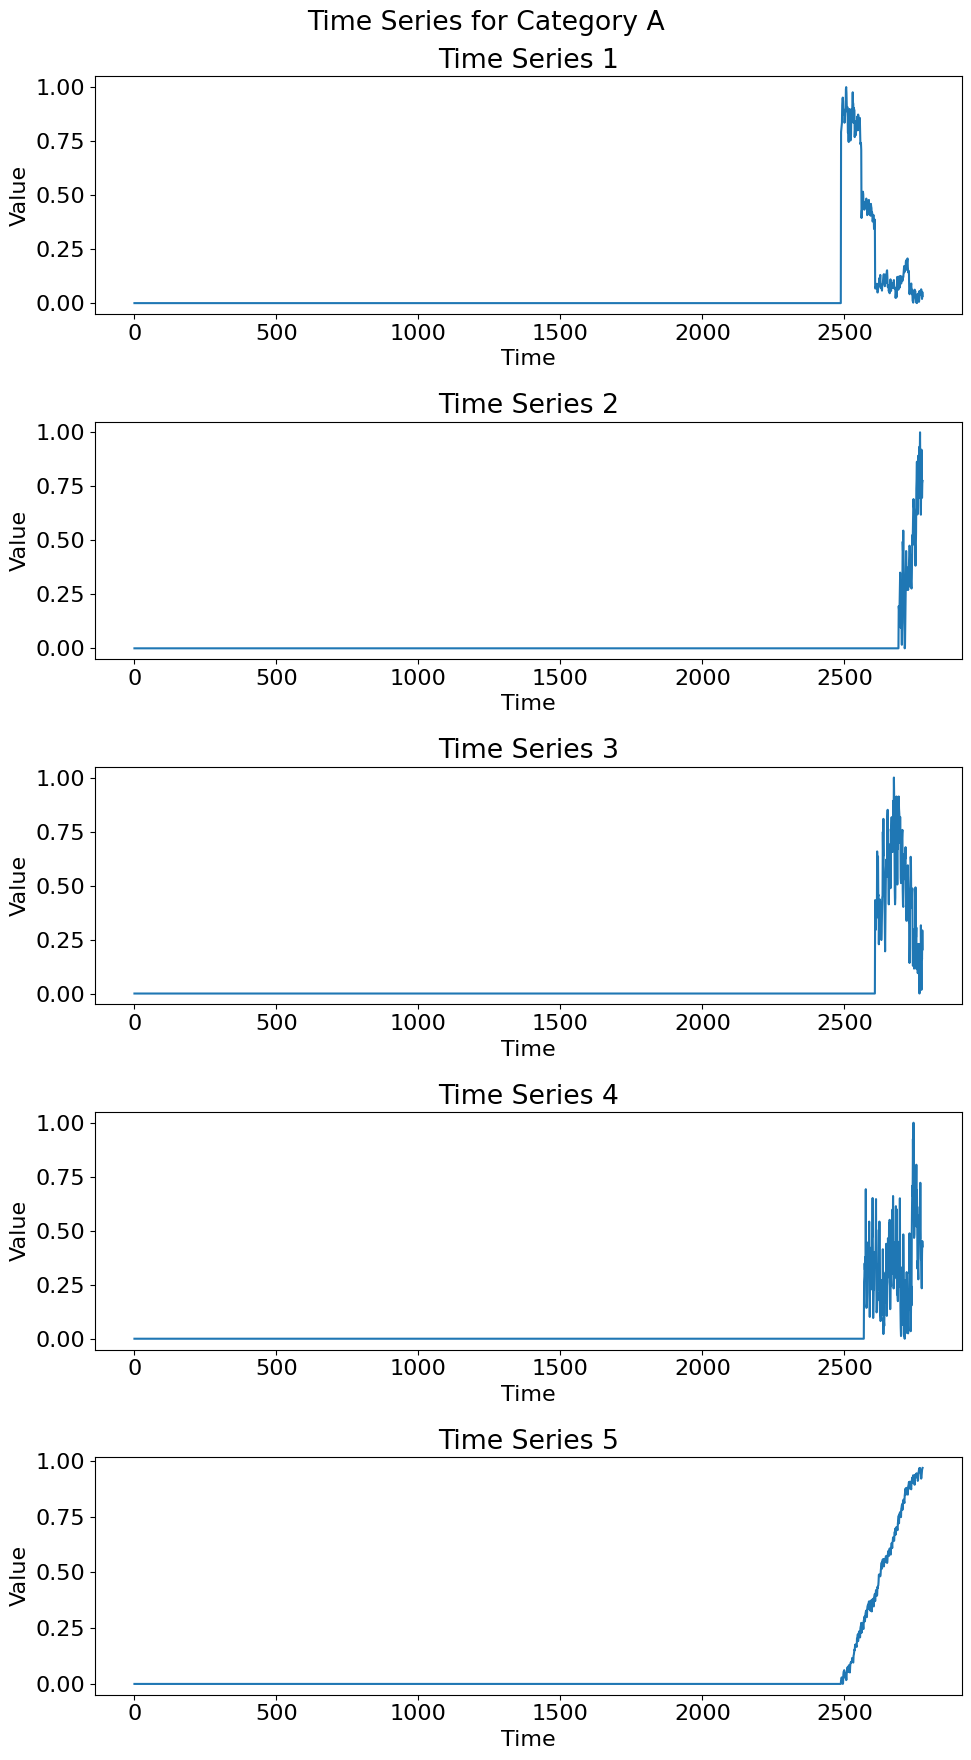

In [15]:
inspect_time_series_by_category(dataset, 'A')

In [16]:
# Plot of the start and end indices of the time series

def plot_start_end_indices(df):

    # index and category extraction
    start_indices = df.iloc[:, -2]
    end_indices = df.iloc[:, -1]
    categories = df.iloc[:, -3]

    # Create a plot for the start indices
    plt.figure(figsize=(15, 5))
    for category in df['Category'].unique():
        category_start_indices = start_indices[categories == category]
        plt.scatter(category_start_indices.index, category_start_indices, label=category)

    plt.title("Start Indices by Category")
    plt.xlabel("Data Points")
    plt.ylabel("Start Indices")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Create a plot for the end indices
    plt.figure(figsize=(15, 5))
    for category in df['Category'].unique():
        category_end_indices = end_indices[categories == category]
        plt.scatter(category_end_indices.index, category_end_indices, label=category)

    plt.title("End Indices by Category")
    plt.xlabel("Data Points")
    plt.ylabel("End Indices")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

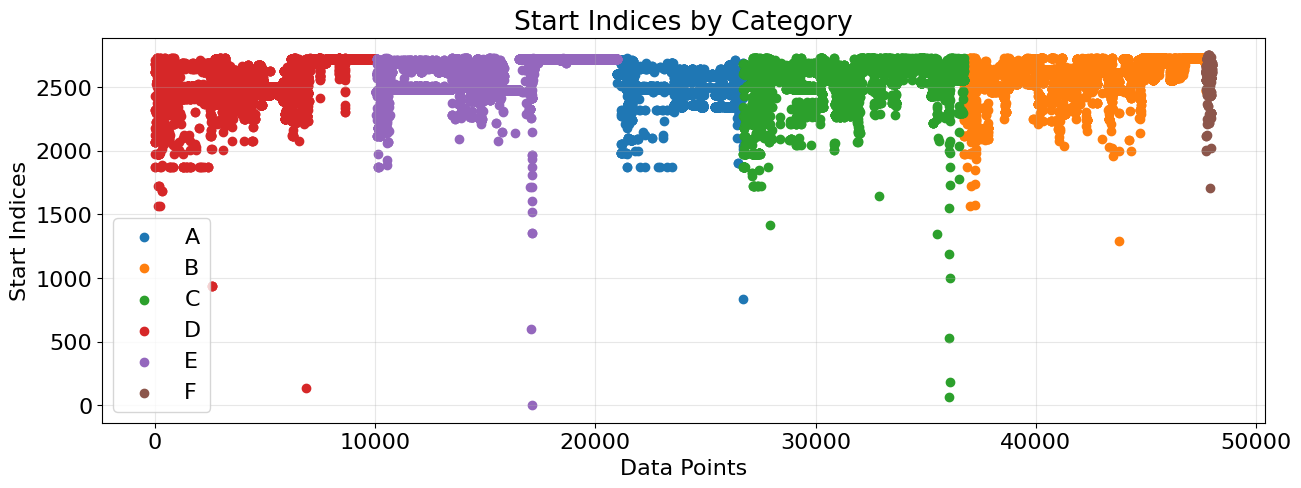

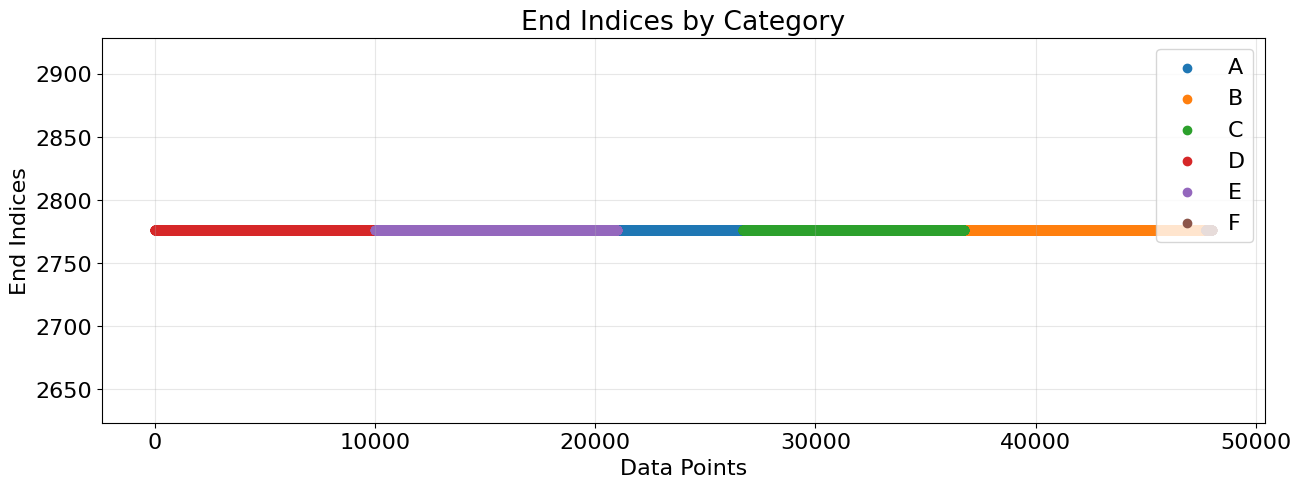

In [17]:
plot_start_end_indices(dataset)

In [18]:
# Filtering the DataFrame to eliminate rows with 'Start_index' < 2000
dataset = dataset.loc[dataset.iloc[:, -2] >= 2000]

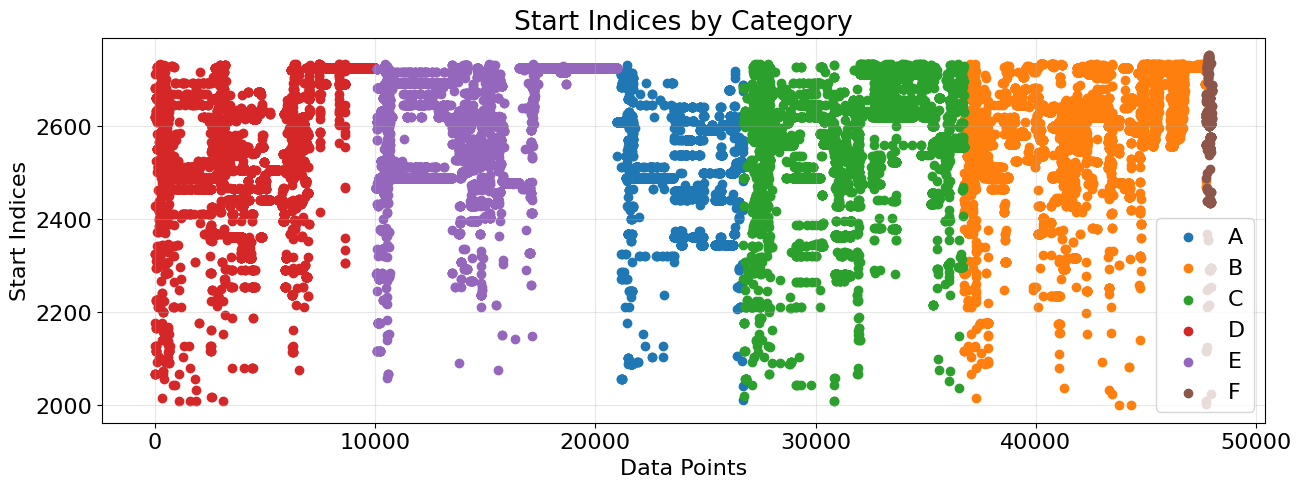

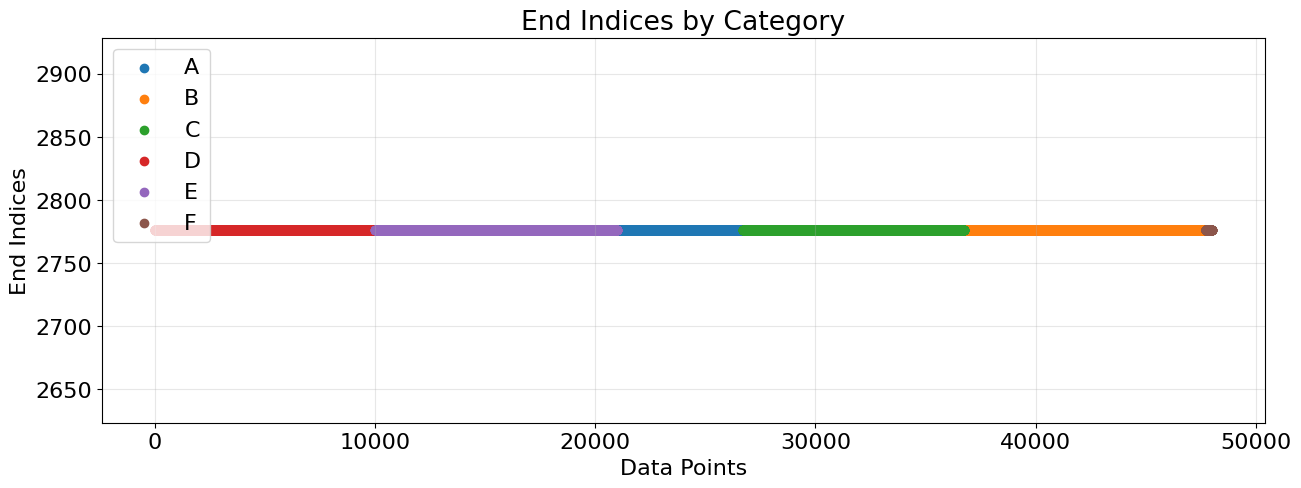

In [19]:
plot_start_end_indices(dataset)

In [20]:
print("number of element per category")
print(dataset['Category'].value_counts())

print("\nTotal number number of raw/Time series: ",len(dataset))

number of element per category
B    10967
E    10955
D     9951
C     9900
A     5697
F      276
Name: Category, dtype: int64

Total number number of raw/Time series:  47746


In [ ]:
# Function to identify time series outliers

def count_outliers(sequence):
    mean = sequence.mean()
    std_dev = sequence.std()

    # Soglia per identificare gli outlier (ad esempio, considerando 3 deviazioni standard dalla media)
    threshold = 3 * std_dev

    # Identifica gli outlier nella sequenza
    outliers = sequence[(sequence < mean - threshold) | (sequence > mean + threshold)]

    return outliers

# Calculate the number of outliers for each category
for category in dataset['Category'].unique():
    category_data = dataset[dataset['Category'] == category]

    outlier_counts = []
    for _, row in category_data.iterrows():
        # Extract the sequence related to the current row (between start index and end index)
        sequence = row.values[row['Start_index']:row['End_index']]

        # Count outliers  in % for the sequence
        outliers = count_outliers(sequence)
        outlier_counts.append(len(outliers) / len(sequence))

    # Calculates the average percentage of outliers for the category
    average_outlier_percentage = np.mean(outlier_counts) * 100
    print(f"Category {category}: {average_outlier_percentage:.2f}% outlier")


Category A: 0.12% outlier
Category B: 0.42% outlier
Category C: 0.35% outlier
Category D: 0.23% outlier
Category E: 0.24% outlier
Category F: 0.26% outlier


In [21]:
# Train test split

def split_train_test(ds):
    # I just extract the category
    categories = ds.iloc[:, -3]

    train_val_data = pd.DataFrame()
    test_data = pd.DataFrame()

    for category in categories.unique():
        data_by_category = ds[ds.iloc[:, -3] == category]

        # Split per category
        train_val_cat, test_cat = train_test_split(data_by_category, test_size=0.1, random_state=42)

        # Concatenate the subdivisions by category
        train_val_data = pd.concat([train_val_data, train_val_cat])
        test_data = pd.concat([test_data, test_cat])

    return train_val_data, test_data


In [22]:
X_train, X_test = split_train_test(dataset) #split

# Count the occurrences of each category
category_counts = X_test['Category'].value_counts()

# Prints the number of values for each category
print("\nFor test sets of the various categories")
for category, count in category_counts.items():
    print(f"Category {category}: {count} values")


For test sets of the various categories
Category B: 1097 values
Category E: 1096 values
Category D: 996 values
Category C: 990 values
Category A: 570 values
Category F: 28 values


In [ ]:
# ATTENTION:
# X_train and y_train still have the last 3 columns with category and indexes

In [23]:
window=200
stride=5
telescope=18 # 9 phase1, 18 phase2

category='A'

In [24]:
def build_sequence(df, category, window, stride, telescope):
    dataset = []  # It will be X_train or X_test
    labels = []  # It will be Y_train or Y_test

    category_data = df[df['Category'] == category]

    # For each category, for each row/time series, I create sequences and labels
    for _, row in category_data.iterrows():
        sequence = row.values[row['Start_index']:row['End_index']]

        for idx in np.arange(0, len(sequence) - window - telescope, stride):
            dataset.append(sequence[idx:idx + window])
            labels.append(sequence[idx + window:idx + window + telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)

    return dataset, labels


In [25]:
X_train, y_train = build_sequence(X_train, category, window, stride, telescope)
print(X_train.shape, y_train.shape)


# Now X_train and y_train contain only time series
print(X_train.dtype)
print(y_train.dtype)

(75771, 200) (75771, 18)
object
object


In [26]:
# the data for the .fit must all be in float32 after
try:
    X_train = X_train.astype(np.float32)
    y_train = y_train.astype(np.float32)
except ValueError as e:
    print("Errore di conversione:", e)

print(X_train.shape, y_train.shape)
print(X_train.dtype)
print(y_train.dtype)

(75771, 200) (75771, 18)
float32
float32


In [27]:
# with LSTM the data must be of the form [num_samples, time_steps, features].
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))

X_train.shape, y_train.shape

((75771, 200, 1), (75771, 18, 1))

In [28]:
# I do the same for the Test set

X_test, y_test = build_sequence(X_test, category, window, stride, telescope)

X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 1))

print(X_test.shape, y_test.shape)
print(X_test.dtype, y_test.dtype)


(8739, 200, 1) (8739, 18, 1)
float32 float32


In [29]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 80

print(input_shape)
print(output_shape)

(200, 1)
(18, 1)


# Bidir_LSTM + Conv.

In [30]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0]

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with some units
    x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer (filters, kernel size)
    x = tfkl.Conv1D(32, 5, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 5, padding='same', name='output_layer')(x)
    # To have the shape (None, telescope)
    output_layer = tf.keras.layers.Flatten(name='flatten')(output_layer)
    output_layer = tf.keras.layers.Dense(output_shape[0], name='dense_output')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 bidirectional_lstm (Bidire  (None, 200, 256)          133120    
 ctional)                                                        
                                                                 
 conv (Conv1D)               (None, 200, 32)           40992     
                                                                 
 output_layer (Conv1D)       (None, 200, 1)            161       
                                                                 
 flatten (Flatten)           (None, 200)               0         
                                                                 
 dense_output (Dense)        (None, 18)                3618      
                                                   

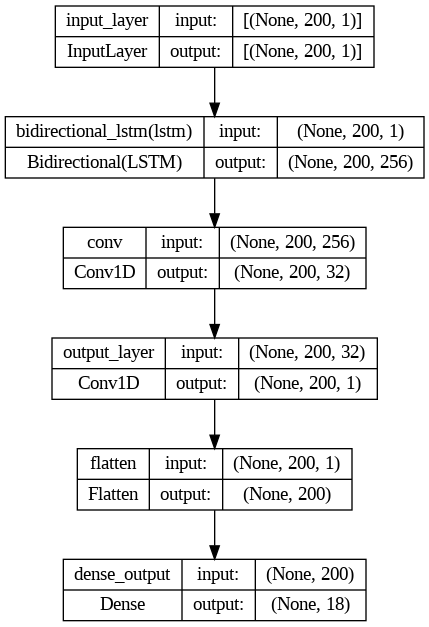

In [31]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [32]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min',min_delta=0.0001, patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/80
1066/1066 [==============================] - 34s 23ms/step - loss: 0.0215 - val_loss: 0.0120 - lr: 0.0010
Epoch 2/80
1066/1066 [==============================] - 21s 20ms/step - loss: 0.0107 - val_loss: 0.0109 - lr: 0.0010
Epoch 3/80
1066/1066 [==============================] - 21s 19ms/step - loss: 0.0101 - val_loss: 0.0106 - lr: 0.0010
Epoch 4/80
1066/1066 [==============================] - 21s 20ms/step - loss: 0.0095 - val_loss: 0.0102 - lr: 0.0010
Epoch 5/80
1066/1066 [==============================] - 21s 20ms/step - loss: 0.0091 - val_loss: 0.0096 - lr: 0.0010
Epoch 6/80
1066/1066 [==============================] - 21s 20ms/step - loss: 0.0088 - val_loss: 0.0099 - lr: 0.0010
Epoch 7/80
1066/1066 [==============================] - 22s 21ms/step - loss: 0.0086 - val_loss: 0.0093 - lr: 0.0010
Epoch 8/80
1066/1066 [==============================] - 21s 20ms/step - loss: 0.0085 - val_loss: 0.0090 - lr: 0.0010
Epoch 9/80
1066/1066 [==============================] - 22s 20ms

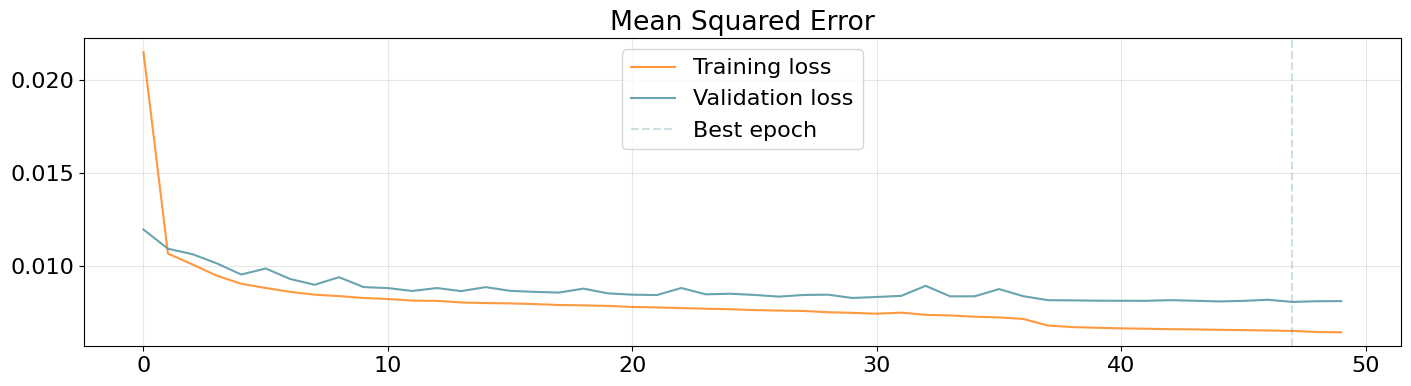

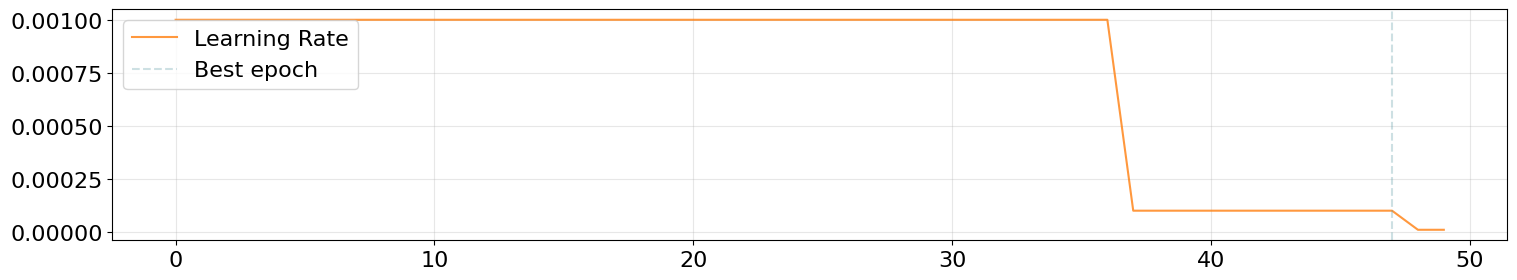

In [33]:
# plot for the error
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

#plot for the learning rate
plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [34]:
# Test evaluation

# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (8739, 18)
Mean Squared Error: 0.0073033845983445644
Mean Absolute Error: 0.05544891580939293


In [35]:
# comparison between X_test, y_test and predictions

def plot_comparison(X_test, y_test, predictions, idx):
    # Random row
    random_idx = random.randint(0, len(X_test) - 1)

    # If idx is specified, use that instead of a random choice
    if idx is not None:
        random_idx = idx

    # Get the corresponding time series
    x_series = X_test[random_idx]
    y_series = y_test[random_idx]
    predicted_series = predictions[random_idx]

    plt.figure(figsize=(15, 6))

    # Plot of the first part (X_test)
    plt.plot(range(len(x_series)), x_series, label='X_test', color='blue')

    # Plot of predicted values (predictions)
    plt.plot(range(len(x_series), len(x_series) + len(predicted_series)), predicted_series, label='Predictions', color='green')

    # Real value plot (y_test)
    plt.plot(range(len(x_series), len(x_series) + len(y_series)), y_series, label='y_test', color='orange')

    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Comparison of X_test, Predictions, and y_test')
    plt.show()


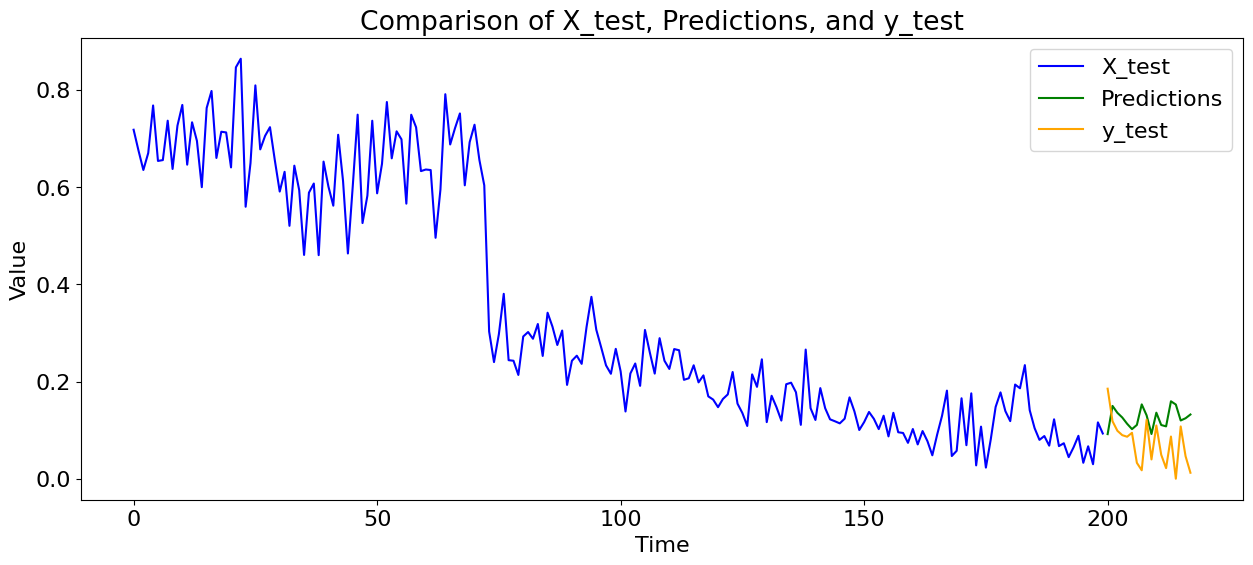

In [36]:
# Using the function to view a single time series
plot_comparison(X_test, y_test, predictions, idx=None)

In [37]:
model.save('BiLSTM_Conv_catA')

# LSTM

In [40]:
def build_lstm_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0]

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a LSTM layer with some units
    x = tfkl.LSTM(256, return_sequences=False, name='lstm')(input_layer)

    # Add another LSTM layer with 64 units
    #x = tfkl.LSTM(64, return_sequences=False, name='lstm_2')(x)

    # Add output layer
    output_layer = tfkl.Dense(units=output_shape[0], name='output_layer')(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 output_layer (Dense)        (None, 18)                4626      
                                                                 
Total params: 268818 (1.03 MB)
Trainable params: 268818 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


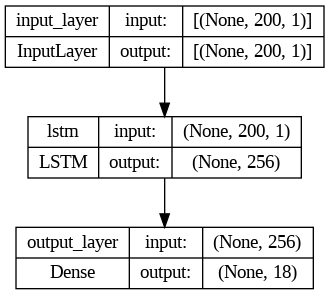

In [41]:
model = build_lstm_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [42]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/80
1066/1066 [==============================] - 19s 15ms/step - loss: 0.0144 - val_loss: 0.0116 - lr: 0.0010
Epoch 2/80
1066/1066 [==============================] - 16s 15ms/step - loss: 0.0106 - val_loss: 0.0108 - lr: 0.0010
Epoch 3/80
1066/1066 [==============================] - 16s 15ms/step - loss: 0.0103 - val_loss: 0.0112 - lr: 0.0010
Epoch 4/80
1066/1066 [==============================] - 16s 15ms/step - loss: 0.0101 - val_loss: 0.0107 - lr: 0.0010
Epoch 5/80
1066/1066 [==============================] - 16s 15ms/step - loss: 0.0098 - val_loss: 0.0104 - lr: 0.0010
Epoch 6/80
1066/1066 [==============================] - 16s 15ms/step - loss: 0.0096 - val_loss: 0.0107 - lr: 0.0010
Epoch 7/80
1066/1066 [==============================] - 16s 15ms/step - loss: 0.0095 - val_loss: 0.0104 - lr: 0.0010
Epoch 8/80
1066/1066 [==============================] - 16s 15ms/step - loss: 0.0094 - val_loss: 0.0097 - lr: 0.0010
Epoch 9/80
1066/1066 [==============================] - 16s 15ms

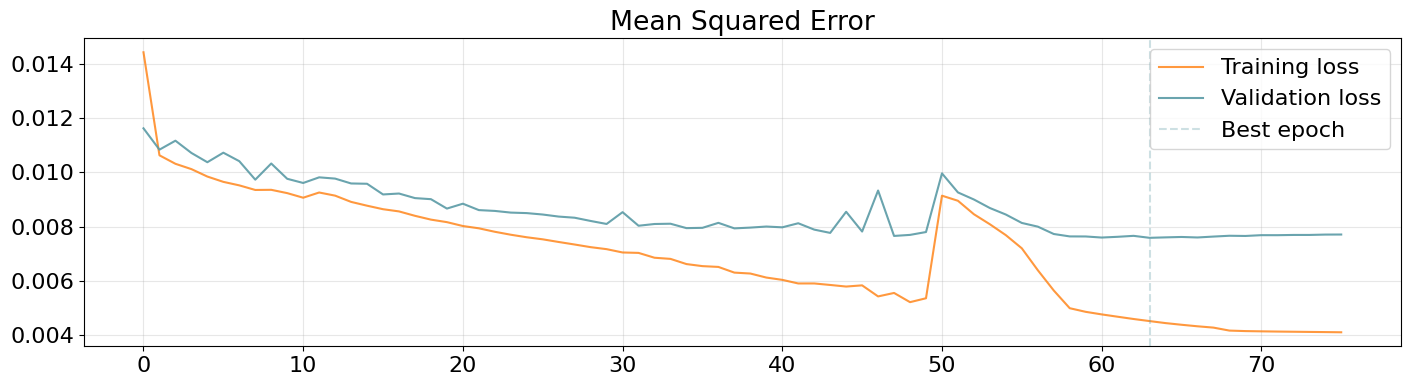

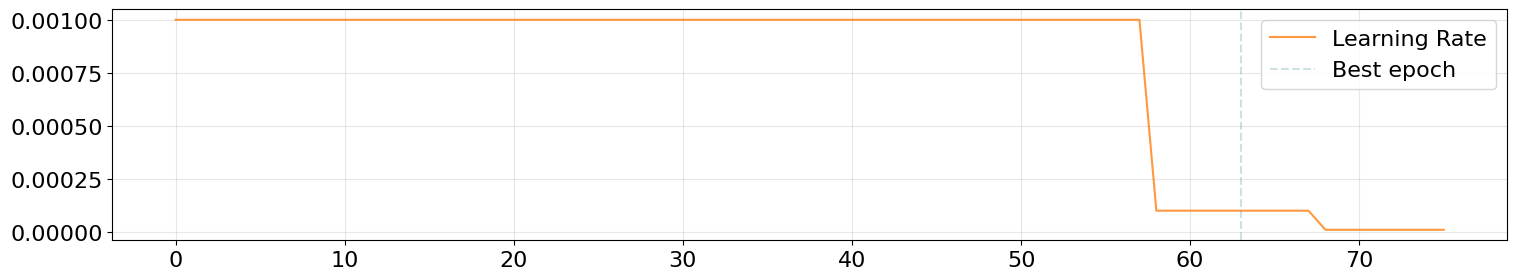

In [43]:
# plot for the error
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

#plot for the learning rate
plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [44]:
# Test evaluation

# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (8739, 18)
Mean Squared Error: 0.007113967090845108
Mean Absolute Error: 0.05486634746193886


In [45]:
# comparison between X_test, y_test and predictions

def plot_comparison(X_test, y_test, predictions, idx):
    # Random row
    random_idx = random.randint(0, len(X_test) - 1)

    # If idx is specified, use that instead of a random choice
    if idx is not None:
        random_idx = idx

    # Get the corresponding time series
    x_series = X_test[random_idx]
    y_series = y_test[random_idx]
    predicted_series = predictions[random_idx]

    plt.figure(figsize=(15, 6))

    # Plot of the first part (X_test)
    plt.plot(range(len(x_series)), x_series, label='X_test', color='blue')

    # Plot of predicted values (predictions)
    plt.plot(range(len(x_series), len(x_series) + len(predicted_series)), predicted_series, label='Predictions', color='green')

    # Real value plot (y_test)
    plt.plot(range(len(x_series), len(x_series) + len(y_series)), y_series, label='y_test', color='orange')

    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Comparison of X_test, Predictions, and y_test')
    plt.show()

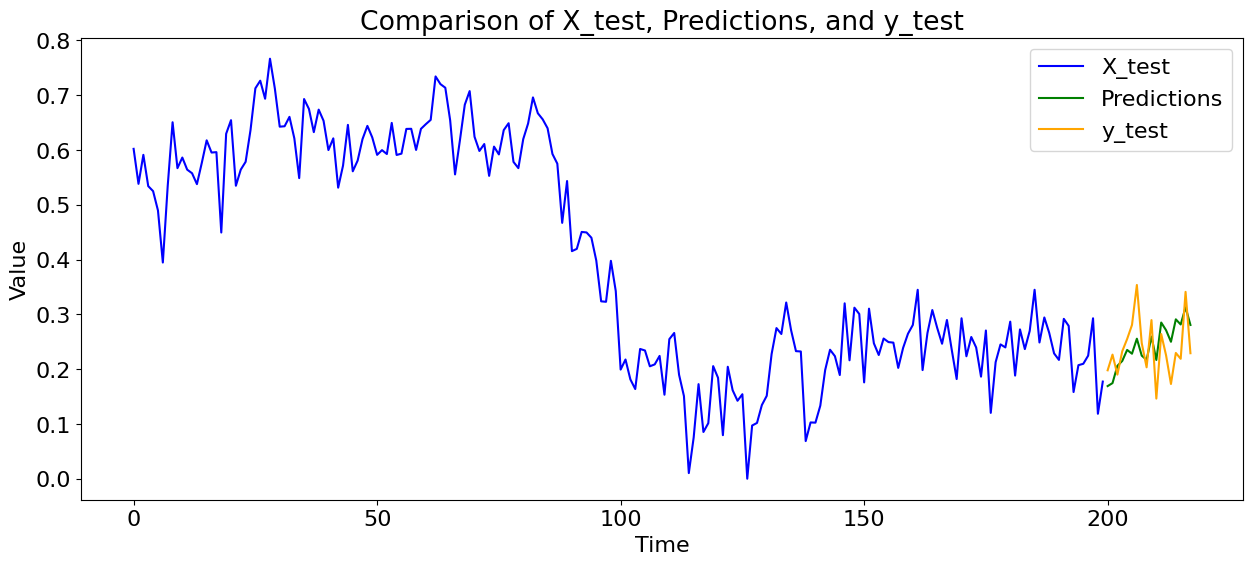

In [46]:
plot_comparison(X_test, y_test, predictions, idx=None)

In [47]:
model.save('LSTM_catA')

# Bidir_LSTM

In [48]:
def build_bidir_lstm_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0]

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a LSTM layer with some units
    x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=False, name='Bidir_lstm'))(input_layer)

    # add output layer
    output_layer = tfkl.Dense(units=output_shape[0], name='output_layer')(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 bidirectional (Bidirection  (None, 256)               133120    
 al)                                                             
                                                                 
 output_layer (Dense)        (None, 18)                4626      
                                                                 
Total params: 137746 (538.07 KB)
Trainable params: 137746 (538.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


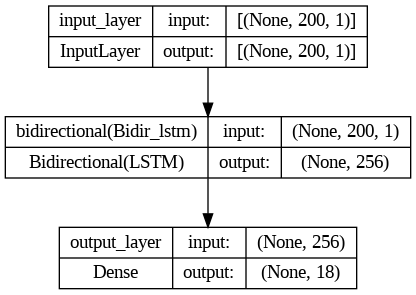

In [49]:
model = build_bidir_lstm_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [50]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0001, patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/80
1066/1066 [==============================] - 23s 18ms/step - loss: 0.0150 - val_loss: 0.0114 - lr: 0.0010
Epoch 2/80
1066/1066 [==============================] - 19s 18ms/step - loss: 0.0105 - val_loss: 0.0108 - lr: 0.0010
Epoch 3/80
1066/1066 [==============================] - 19s 18ms/step - loss: 0.0102 - val_loss: 0.0109 - lr: 0.0010
Epoch 4/80
1066/1066 [==============================] - 19s 18ms/step - loss: 0.0099 - val_loss: 0.0105 - lr: 0.0010
Epoch 5/80
1066/1066 [==============================] - 18s 17ms/step - loss: 0.0097 - val_loss: 0.0102 - lr: 0.0010
Epoch 6/80
1066/1066 [==============================] - 18s 17ms/step - loss: 0.0094 - val_loss: 0.0104 - lr: 0.0010
Epoch 7/80
1066/1066 [==============================] - 19s 18ms/step - loss: 0.0093 - val_loss: 0.0103 - lr: 0.0010
Epoch 8/80
1066/1066 [==============================] - 19s 17ms/step - loss: 0.0093 - val_loss: 0.0102 - lr: 0.0010
Epoch 9/80
1066/1066 [==============================] - 18s 17ms

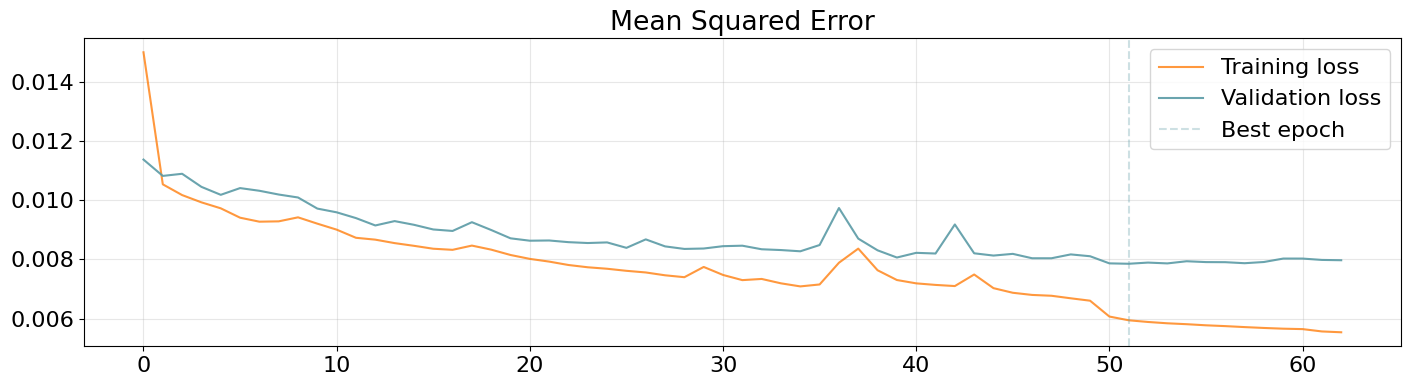

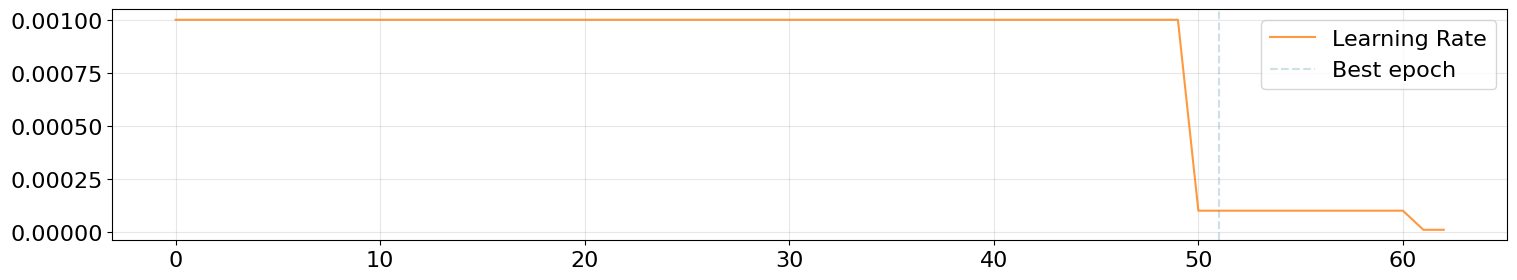

In [51]:
# plot for the error
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

#plot for the learning rate
plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [52]:
# Test evaluation

# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (8739, 18)
Mean Squared Error: 0.007235233671963215
Mean Absolute Error: 0.055267270654439926


In [53]:
# comparison between X_test, y_test and predictions

def plot_comparison(X_test, y_test, predictions, idx):
    # Random row
    random_idx = random.randint(0, len(X_test) - 1)

    # If idx is specified, use that instead of a random choice
    if idx is not None:
        random_idx = idx

    # Get the corresponding time series
    x_series = X_test[random_idx]
    y_series = y_test[random_idx]
    predicted_series = predictions[random_idx]

    plt.figure(figsize=(15, 6))

    # Plot of the first part (X_test)
    plt.plot(range(len(x_series)), x_series, label='X_test', color='blue')

    # Plot of predicted values (predictions)
    plt.plot(range(len(x_series), len(x_series) + len(predicted_series)), predicted_series, label='Predictions', color='green')

    # Real value plot (y_test)
    plt.plot(range(len(x_series), len(x_series) + len(y_series)), y_series, label='y_test', color='orange')

    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Comparison of X_test, Predictions, and y_test')
    plt.show()

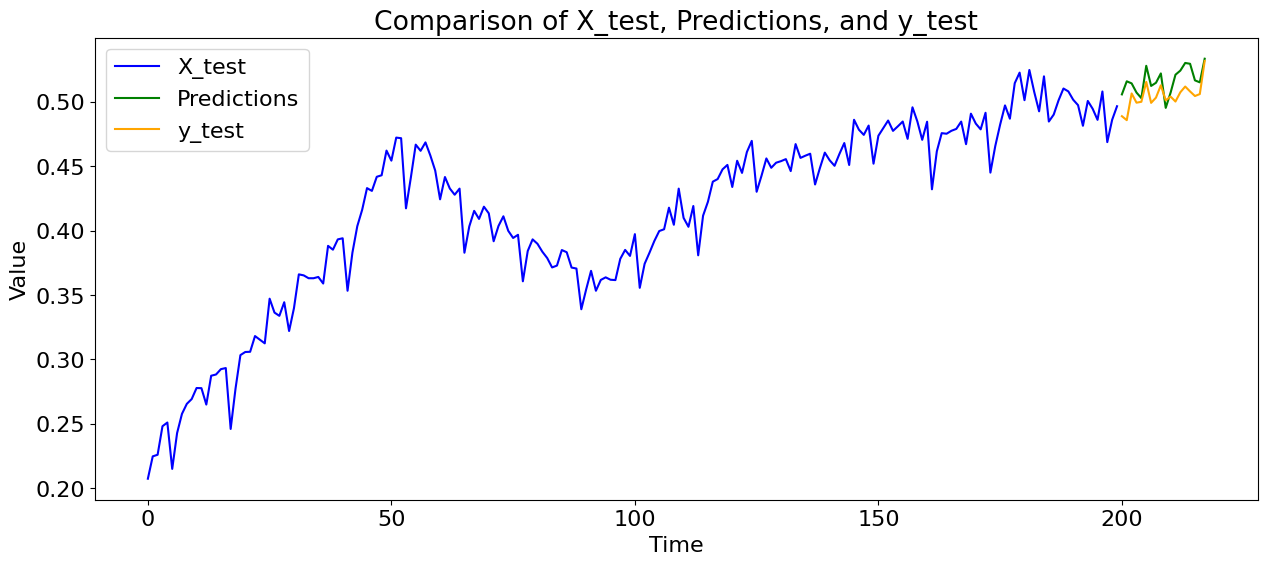

In [54]:
plot_comparison(X_test, y_test, predictions, idx=None)

In [55]:
model.save('Bidir_LSTM_catA')

# Bidir_LSTM + Dropout

In [56]:
def build_bidir_lstm_drop_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0]

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a LSTM layer with some units
    x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=False, name='Bidir_lstm1'))(input_layer)
    #try to add other layers
    #x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=False, name='Bidir_lstm2'))(x)


    # Add a Dropout layer
    x = tfkl.Dropout(0.2)(x)

    # add output layer
    output_layer = tfkl.Dense(units=output_shape[0], name='output_layer')(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               133120    
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 output_layer (Dense)        (None, 18)                4626      
                                                                 
Total params: 137746 (538.07 KB)
Trainable params: 137746 (538.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


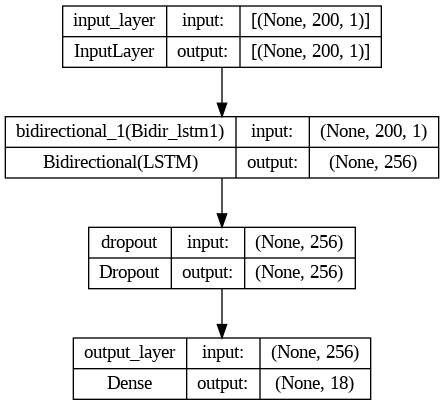

In [57]:
model = build_bidir_lstm_drop_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [58]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min',min_delta=0.0001, patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/80
1066/1066 [==============================] - 27s 18ms/step - loss: 0.0170 - val_loss: 0.0118 - lr: 0.0010
Epoch 2/80
1066/1066 [==============================] - 19s 18ms/step - loss: 0.0116 - val_loss: 0.0113 - lr: 0.0010
Epoch 3/80
1066/1066 [==============================] - 19s 18ms/step - loss: 0.0111 - val_loss: 0.0115 - lr: 0.0010
Epoch 4/80
1066/1066 [==============================] - 18s 17ms/step - loss: 0.0108 - val_loss: 0.0108 - lr: 0.0010
Epoch 5/80
1066/1066 [==============================] - 19s 18ms/step - loss: 0.0106 - val_loss: 0.0108 - lr: 0.0010
Epoch 6/80
1066/1066 [==============================] - 21s 20ms/step - loss: 0.0104 - val_loss: 0.0108 - lr: 0.0010
Epoch 7/80
1066/1066 [==============================] - 18s 17ms/step - loss: 0.0102 - val_loss: 0.0105 - lr: 0.0010
Epoch 8/80
1066/1066 [==============================] - 18s 17ms/step - loss: 0.0100 - val_loss: 0.0102 - lr: 0.0010
Epoch 9/80
1066/1066 [==============================] - 19s 18ms

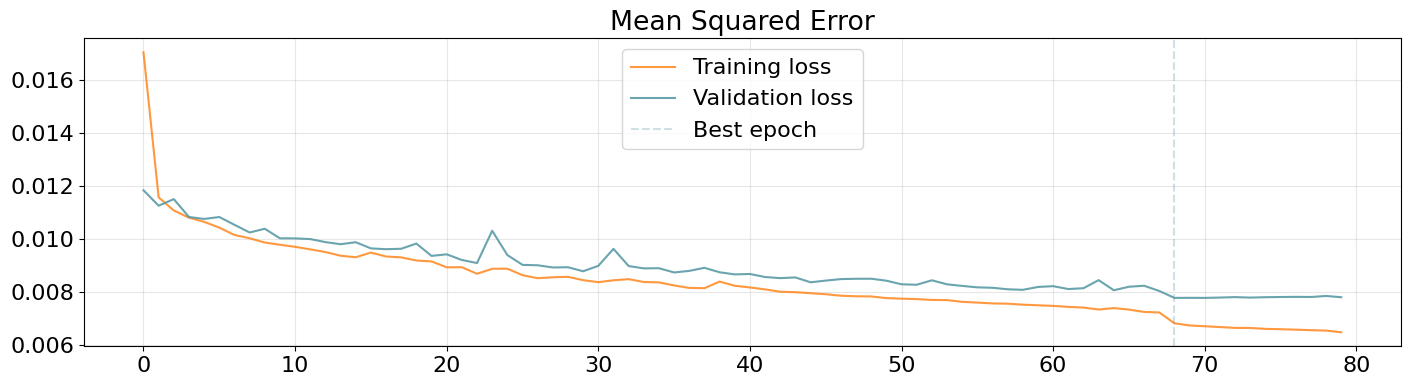

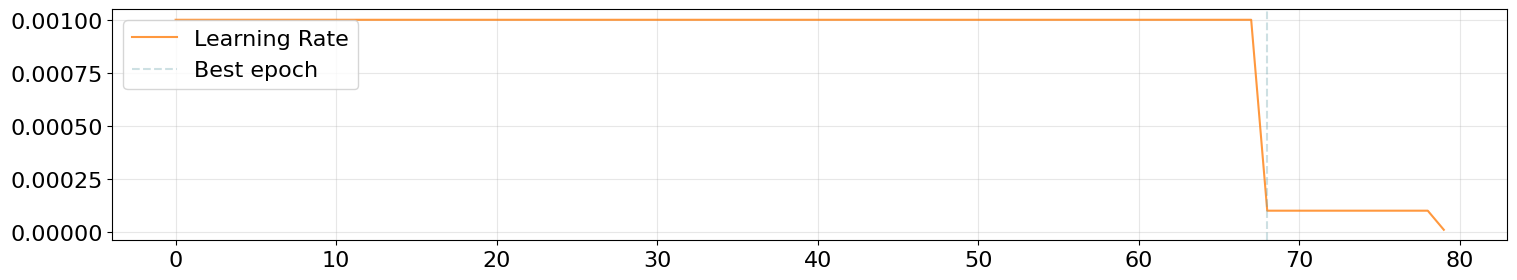

In [59]:
# plot for the error
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

#plot for the learning rate
plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [60]:
# Test evaluation

# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (8739, 18)
Mean Squared Error: 0.0072495099157094955
Mean Absolute Error: 0.05561624839901924


In [61]:
# comparison between X_test, y_test and predictions

def plot_comparison(X_test, y_test, predictions, idx):
    # Random row
    random_idx = random.randint(0, len(X_test) - 1)

    # If idx is specified, use that instead of a random choice
    if idx is not None:
        random_idx = idx

    # Get the corresponding time series
    x_series = X_test[random_idx]
    y_series = y_test[random_idx]
    predicted_series = predictions[random_idx]

    plt.figure(figsize=(15, 6))

    # Plot of the first part (X_test)
    plt.plot(range(len(x_series)), x_series, label='X_test', color='blue')

    # Plot of predicted values (predictions)
    plt.plot(range(len(x_series), len(x_series) + len(predicted_series)), predicted_series, label='Predictions', color='green')

    # Real value plot (y_test)
    plt.plot(range(len(x_series), len(x_series) + len(y_series)), y_series, label='y_test', color='orange')

    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Comparison of X_test, Predictions, and y_test')
    plt.show()

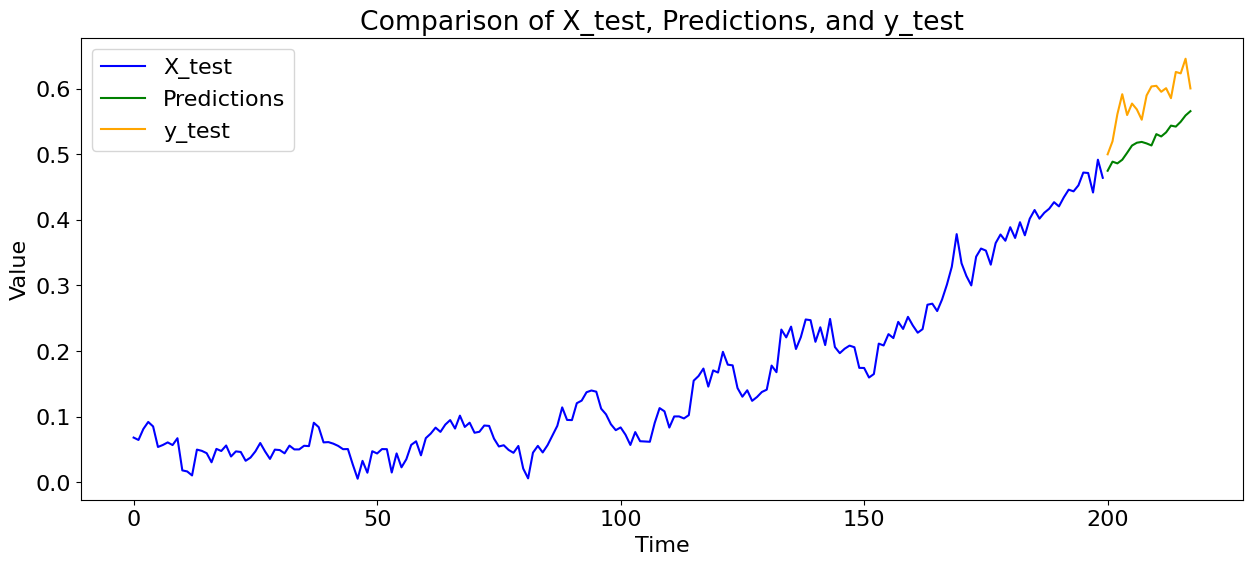

In [62]:
plot_comparison(X_test, y_test, predictions, idx=None)

In [63]:
model.save('Bidir_LSTM_dop_catA')

# ResNet-Like

In [65]:
def conv_block(x, filters, kernel_size):
    conv1 = tfkl.Conv1D(filters, kernel_size, padding='same', activation='relu')(x)
    conv2 = tfkl.Conv1D(filters, kernel_size, padding='same', activation='linear')(conv1)

    # Skip connection
    x = tfkl.Add()([x, conv2])
    return x

def build_resnet_model(input_shape, output_shape):
    input_layer = tfkl.Input(shape=input_shape)
    x = input_layer

    x = tfkl.Conv1D(64, 3, padding='same', activation='relu')(x)
    x = tfkl.MaxPooling1D(2)(x)

    # Conv blocks
    x = conv_block(x, filters=64, kernel_size=3)
    x = conv_block(x, filters=64, kernel_size=5)
    x = conv_block(x, filters=64, kernel_size=7)

    # Global average pooling to obtain a vector
    x = tfkl.GlobalAveragePooling1D()(x)

    # add output layer
    output_layer = tfkl.Dense(units=output_shape[0], name='output_layer')(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='ResNet_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())
    return model


Model: "ResNet_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 200, 64)              256       ['input_1[0][0]']             
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 100, 64)              0         ['conv1d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv1d_1 (Conv1D)           (None, 100, 64)              12352     ['max_pooling1d[0][

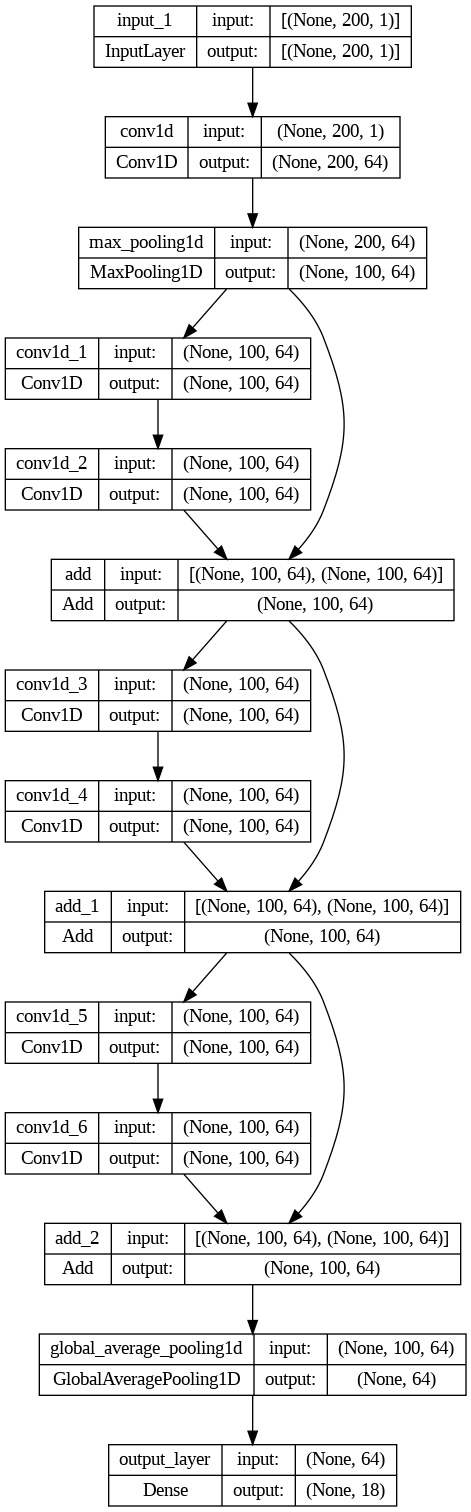

In [66]:
model = build_resnet_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [67]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0001, patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/80
1066/1066 [==============================] - 11s 8ms/step - loss: 0.0172 - val_loss: 0.0111 - lr: 0.0010
Epoch 2/80
1066/1066 [==============================] - 6s 6ms/step - loss: 0.0103 - val_loss: 0.0102 - lr: 0.0010
Epoch 3/80
1066/1066 [==============================] - 7s 7ms/step - loss: 0.0097 - val_loss: 0.0105 - lr: 0.0010
Epoch 4/80
1066/1066 [==============================] - 7s 6ms/step - loss: 0.0094 - val_loss: 0.0104 - lr: 0.0010
Epoch 5/80
1066/1066 [==============================] - 7s 7ms/step - loss: 0.0092 - val_loss: 0.0098 - lr: 0.0010
Epoch 6/80
1066/1066 [==============================] - 7s 6ms/step - loss: 0.0090 - val_loss: 0.0101 - lr: 0.0010
Epoch 7/80
1066/1066 [==============================] - 7s 7ms/step - loss: 0.0088 - val_loss: 0.0091 - lr: 0.0010
Epoch 8/80
1066/1066 [==============================] - 7s 6ms/step - loss: 0.0085 - val_loss: 0.0088 - lr: 0.0010
Epoch 9/80
1066/1066 [==============================] - 7s 7ms/step - loss: 0.0

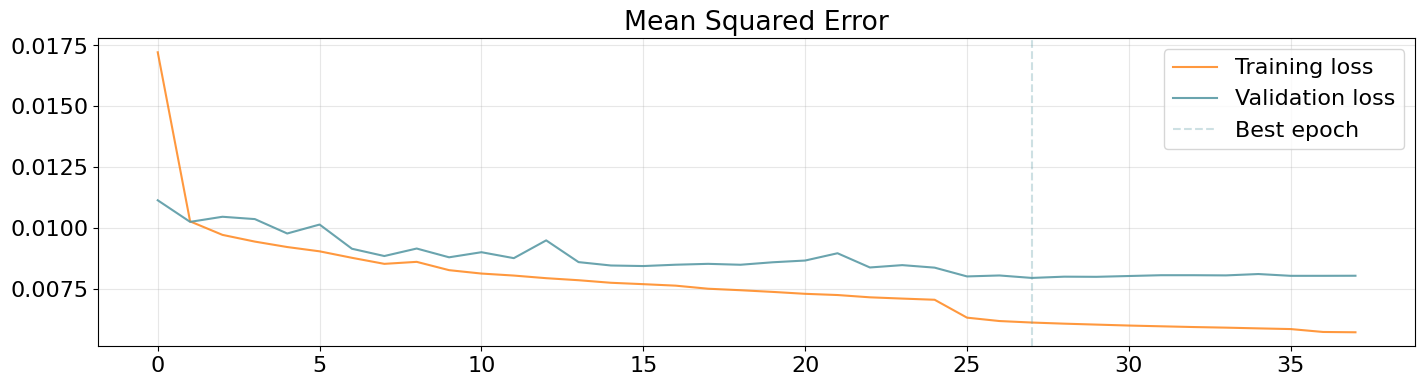

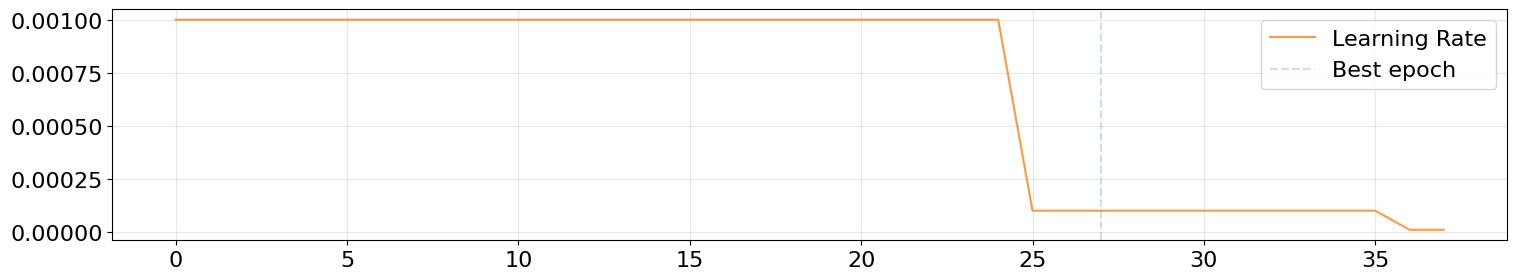

In [68]:
# plot for the error
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

#plot for the learning rate
plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [69]:
# Test evaluation

# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (8739, 18)
Mean Squared Error: 0.007480086293071508
Mean Absolute Error: 0.05715896189212799


In [70]:
def plot_comparison(X_test, y_test, predictions, idx):
    # Prendi una riga a caso
    random_idx = random.randint(0, len(X_test) - 1)

    # Se idx è specificato, usa quello al posto di una scelta casuale
    if idx is not None:
        random_idx = idx

    # Prendi la time series corrispondente
    x_series = X_test[random_idx]
    y_series = y_test[random_idx]
    predicted_series = predictions[random_idx]

    plt.figure(figsize=(15, 6))

    # Plot della prima parte (X_test)
    plt.plot(range(len(x_series)), x_series, label='X_test', color='blue')

    # Plot dei valori predetti (predictions)
    plt.plot(range(len(x_series), len(x_series) + len(predicted_series)), predicted_series, label='Predictions', color='green')

    # Plot dei valori reali (y_test)
    plt.plot(range(len(x_series), len(x_series) + len(y_series)), y_series, label='y_test', color='orange')

    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Comparison of X_test, Predictions, and y_test')
    plt.show()


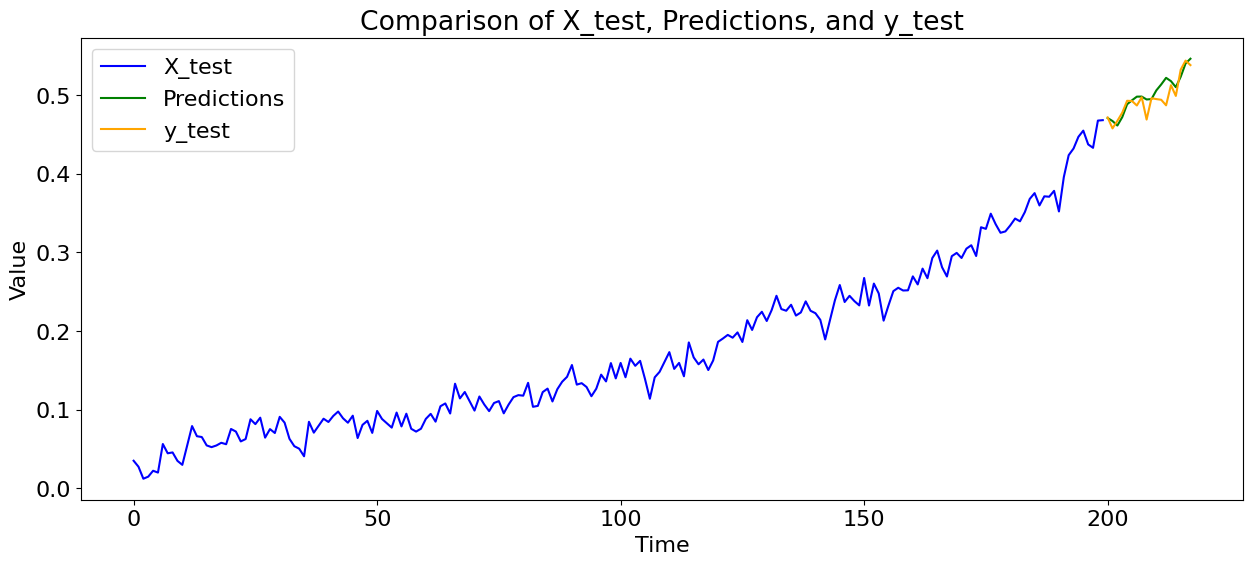

In [71]:
# Utilizzo della funzione per visualizzare una singola time series
plot_comparison(X_test, y_test, predictions, idx=None)

In [72]:
model.save('Resnet_like_catA')

# Simpler Resnet-like

In [82]:
def conv_block(x, filters, kernel_size):
    conv1 = tfkl.Conv1D(filters, kernel_size, padding='same', activation='relu')(x)
    conv2 = tfkl.Conv1D(filters, kernel_size, padding='same', activation='linear')(conv1)
    x = tfkl.Add()([x, conv2])
    return x

def build_simple_resnet_model(input_shape, output_shape):
    input_layer = tfkl.Input(shape=input_shape)
    x = input_layer

    # Initial convolutional layer
    x = tfkl.Conv1D(32, 3, padding='same', activation='relu')(x)
    x = tfkl.MaxPooling1D(2)(x)

    # Residual blocks
    x = conv_block(x, filters=32, kernel_size=3)
    x = conv_block(x, filters=32, kernel_size=5)

    # Global average pooling
    x = tfkl.GlobalAveragePooling1D()(x)

    # Output layer
    output_layer = tfkl.Dense(units=output_shape[0])(x)

    # Construct the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='Simple_ResNet_model')
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model


Model: "Simple_ResNet_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 200, 1)]             0         []                            
                                                                                                  
 conv1d_21 (Conv1D)          (None, 200, 32)              128       ['input_6[0][0]']             
                                                                                                  
 max_pooling1d_5 (MaxPoolin  (None, 100, 32)              0         ['conv1d_21[0][0]']           
 g1D)                                                                                             
                                                                                                  
 conv1d_22 (Conv1D)          (None, 100, 32)              3104      ['max_poolin

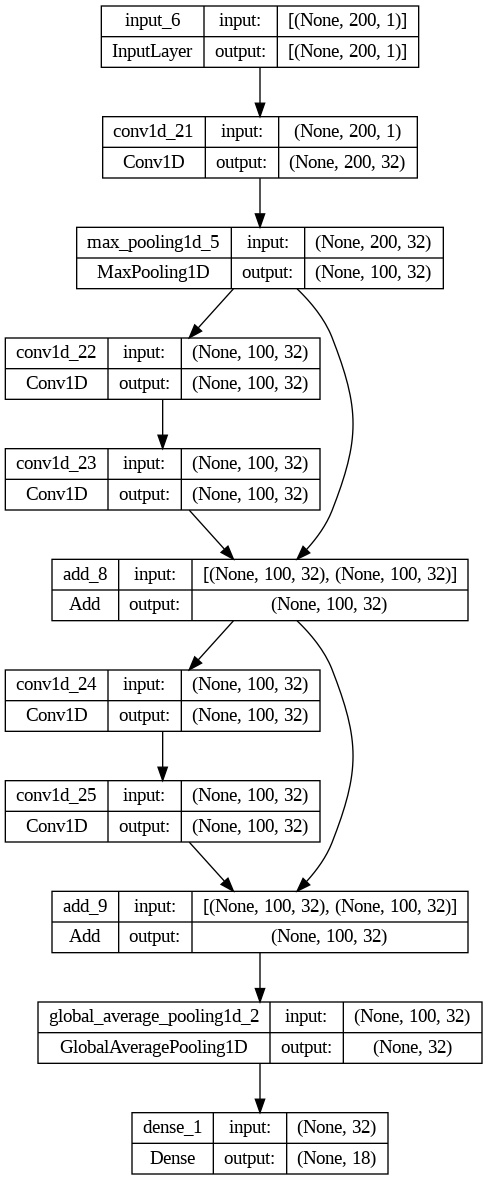

In [83]:
model = build_simple_resnet_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [84]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0001, patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/80
1066/1066 [==============================] - 9s 6ms/step - loss: 0.0282 - val_loss: 0.0122 - lr: 0.0010
Epoch 2/80
1066/1066 [==============================] - 6s 6ms/step - loss: 0.0114 - val_loss: 0.0115 - lr: 0.0010
Epoch 3/80
1066/1066 [==============================] - 5s 5ms/step - loss: 0.0106 - val_loss: 0.0110 - lr: 0.0010
Epoch 4/80
1066/1066 [==============================] - 6s 6ms/step - loss: 0.0101 - val_loss: 0.0106 - lr: 0.0010
Epoch 5/80
1066/1066 [==============================] - 5s 5ms/step - loss: 0.0099 - val_loss: 0.0103 - lr: 0.0010
Epoch 6/80
1066/1066 [==============================] - 5s 5ms/step - loss: 0.0097 - val_loss: 0.0107 - lr: 0.0010
Epoch 7/80
1066/1066 [==============================] - 6s 6ms/step - loss: 0.0096 - val_loss: 0.0100 - lr: 0.0010
Epoch 8/80
1066/1066 [==============================] - 5s 5ms/step - loss: 0.0094 - val_loss: 0.0101 - lr: 0.0010
Epoch 9/80
1066/1066 [==============================] - 6s 6ms/step - loss: 0.00

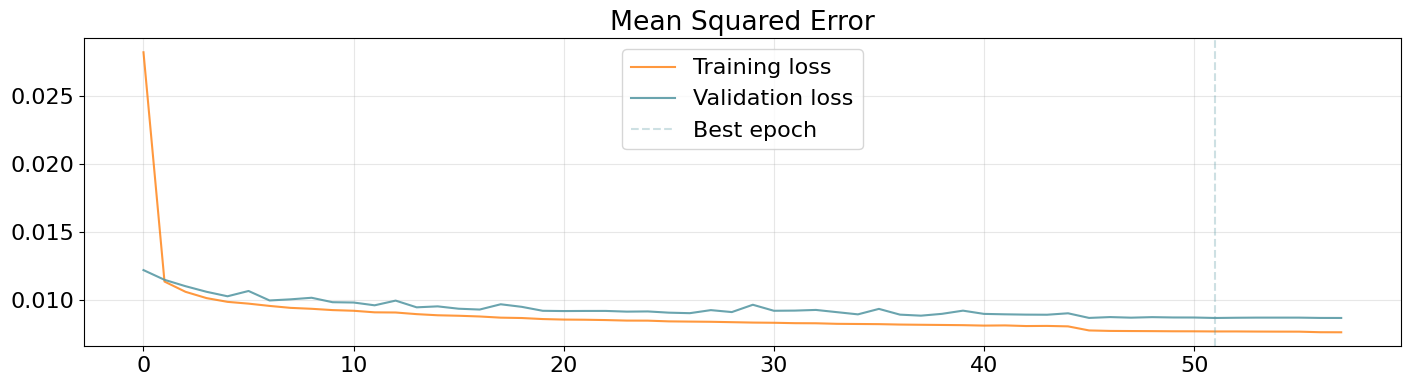

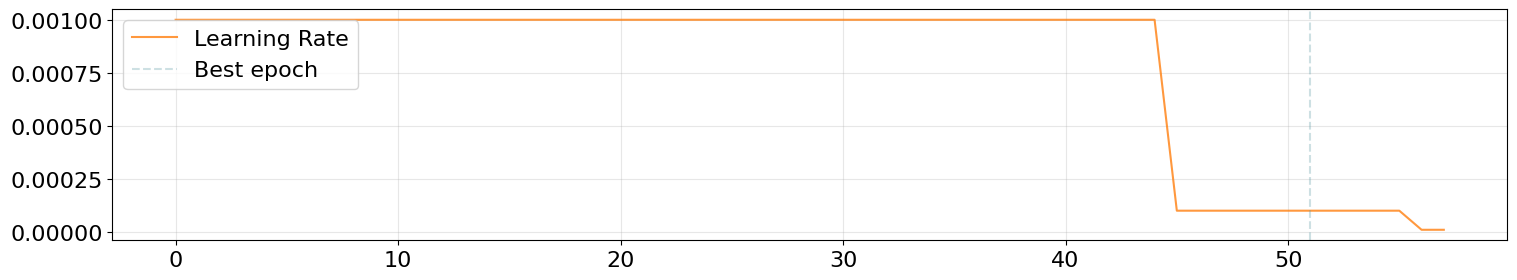

In [85]:
# plot for the error
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

#plot for the learning rate
plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [86]:
# Test evaluation

# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (8739, 18)
Mean Squared Error: 0.007867282256484032
Mean Absolute Error: 0.05861660838127136


In [87]:
model.save('simeple_Resnet_like_catA')